In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('day.csv', index_col = [0])

## checking data

In [3]:
df.count()

dteday        730
season        730
yr            730
mnth          730
holiday       730
weekday       730
workingday    730
weathersit    730
temp          730
atemp         730
hum           730
windspeed     730
casual        730
registered    730
cnt           730
dtype: int64

In [4]:
cat_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

## understading basic info in data - EDA

## target variables corelation with independent categorical variables

<Axes: title={'center': 'Bookings against weather situation'}, ylabel='Frequency'>

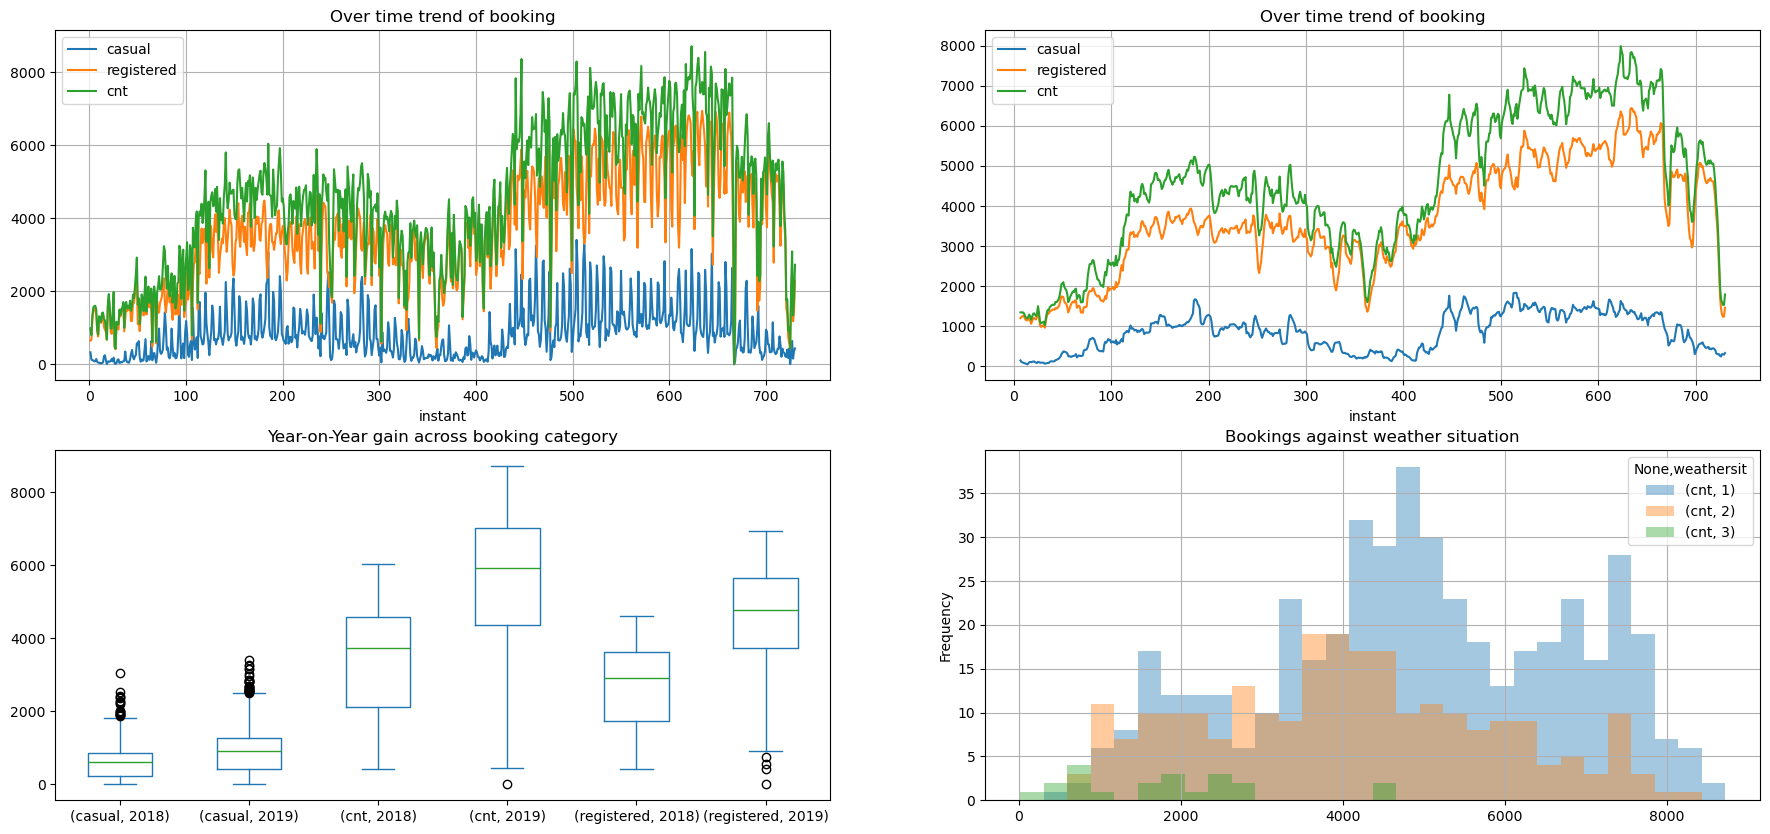

In [5]:
fig, axes = plt.subplots(2,2, figsize = (22,10))
df[['casual','registered','cnt']].plot( grid = True, title = 'Over time trend of booking', ax =axes[0,0] )

## getting rolling plot as fluctuation is because of weekday and weekend
df[['casual','registered','cnt']].rolling(7).mean().plot( grid = True, title = 'Over time trend of booking', ax =axes[0,1] )

## in second year, registered has increased but not casual, checking it in more detail
t_df = df.copy()
t_df['yr'] =  np.where(t_df.yr == 0, '2018', '2019')
t_df[['yr', 'casual','registered','cnt']].reset_index().pivot_table(index = 'instant', columns = 'yr', values = ['casual','registered','cnt']).\
plot(kind = 'box', title = 'Year-on-Year gain across booking category', ax = axes[1,0])

## checking impact with weather conditions
df[['cnt', 'weathersit']].reset_index().pivot_table(index = 'instant', columns = 'weathersit', values = ['cnt'])\
.plot(kind = 'hist', alpha = 0.4, bins = 30, grid = True, title = 'Bookings against weather situation', ax = axes[1,1])


## Take aways
1. Second year was much better than first, buy only for registered users, there was minimal or no change in casual bookings.
2. Hence we will need 2 models separately for 2 types and later sum these 2 answers to get final perfomance
3. Majority of daily level fluctuations in bookings are cleaned at weekly level, meaning weekday (working/not working give some small fluctuations in the booking)
4. Weather has a big impact,
5.     1: Clear, Few clouds, Partly cloudy, Partly cloudy  --- has max bookings
	   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist -- relatively less bookings
	   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds - almost to no bookings

## Corelation with numerical variables

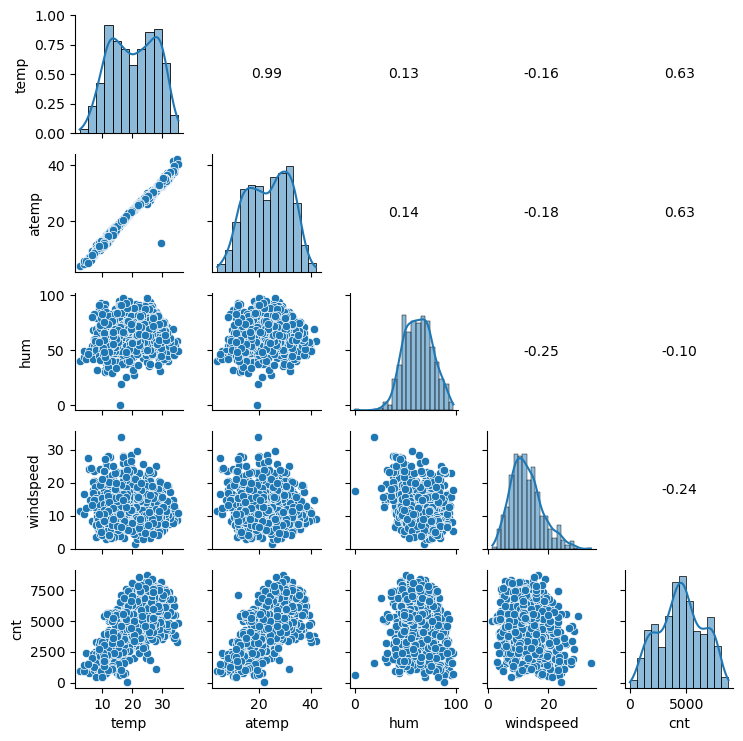

In [6]:
def correlation_coefficient(x, y, **kwargs):
    corr = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.set_axis_off()
    ax.annotate(f"{corr:.2f}", xy=(0.5, 0.5), xycoords="axes fraction", ha="center", va="center", fontsize=10)


g = sns.PairGrid(df[['temp', 'atemp', 'hum', 'windspeed','cnt']],height=1.5)
g.map_lower(sns.scatterplot)
g.map_upper(correlation_coefficient)
g.map_diag(sns.histplot, kde=True)  # Optional: histograms on the diagonal

plt.show()

## takeaways 
1. temperature and real feel metric are highlt correlated and can use only one where real feel looks better approximate
2. humidity and windspeed does not look corelated with 'cnt' variable but still keeping them in first model - look to remove these later

## defining and retainig catagorical variables

In [7]:
cat_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

In [8]:
remove_cols = ['dteday','temp']

In [9]:
df1 = df.loc[:,[col for col in df.columns if col not in remove_cols] ]

In [10]:
## checking variables with 2 and more than 2 unique values
only_2_unique = []
cat_process_vars = []
for var in cat_vars:
    print (var ,'-', (len(df[var].unique())))
    if (len(df[var].unique())) == 2:
        only_2_unique.append(var)
    else:
        cat_process_vars.append(var)

season - 4
yr - 2
mnth - 12
holiday - 2
weekday - 7
workingday - 2
weathersit - 3


### For features with only 2 unique values -
- converting into categorical varaibes only

### For features with more than 2 unique values -
- converting into categorical variabeles and creating dummies

In [11]:
processed_df = pd.concat([df1[only_2_unique].astype(str),
            pd.get_dummies(df1[cat_process_vars].astype(str)).astype(int),
            df1.loc[:,[col for col in df1.columns if col not in cat_vars]]]
            , axis=1)

In [12]:
df1.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt'],
      dtype='object')

In [13]:
df1.season.value_counts()

season
3    188
2    184
1    180
4    178
Name: count, dtype: int64

## importing libraries for training

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score 

In [15]:
train_df, test_df = train_test_split(processed_df, test_size= 0.3, random_state = 3)

In [16]:
X_train = train_df.drop(['casual','registered','cnt'], axis=1)
y_train_reg = train_df.registered
y_train_casual = train_df.casual

X_test = test_df.drop(['casual','registered','cnt'], axis=1)
y_test_reg = test_df.registered
y_test_casual = test_df.casual

## scaling all

In [17]:
x_scaler = StandardScaler()
X_train[['atemp', 'hum', 'windspeed']] = x_scaler.fit_transform(X_train[['atemp', 'hum', 'windspeed']])
X_test[['atemp', 'hum', 'windspeed']] = x_scaler.transform(X_test[['atemp', 'hum', 'windspeed']])

y_reg_scaler = StandardScaler()
y_reg_train_scaled = y_reg_scaler.fit_transform(y_train_reg.values.reshape(-1,1))
y_reg_test_scaled = y_reg_scaler.transform(y_test_reg.values.reshape(-1,1))

y_casual_scaler = StandardScaler()
y_casual_train_scaled = y_casual_scaler.fit_transform(y_train_casual.values.reshape(-1,1))
y_casual_test_scaled = y_casual_scaler.transform(y_test_casual.values.reshape(-1,1))

## training 2 models

In [18]:
lm_reg = LinearRegression()
lm_reg.fit(X_train, y_reg_train_scaled)

LinearRegression()

In [19]:
lm_casual = LinearRegression()
lm_casual.fit(X_train, y_casual_train_scaled)

LinearRegression()

## Predicting on test data

In [20]:
# pd.DataFrame(y_reg_scaler.inverse_transform(lm_reg.predict(X_test)), columns = ['pred_registered'], index = test_df.index).round()

## added an adjustment in predictions -
1. Since number of bookings under each category cannot be below 0
2. Replaced less than 0 predictions with 0

In [21]:
def get_result_on_test_set(X_test, y_reg_scaler,reg_model,casual_model,test_df,y_reg_test_scaled,y_casual_test_scaled):
    registed_test_df = pd.concat([pd.DataFrame(y_reg_scaler.inverse_transform(reg_model.predict(X_test)),columns = ['pred_registered'], index = test_df.index),
                              pd.DataFrame(y_reg_scaler.inverse_transform(y_reg_test_scaled), columns = ['act_registered'], index = test_df.index ) ]
                             , axis=1).round()
    casual_test_df = pd.concat([pd.DataFrame(y_casual_scaler.inverse_transform(casual_model.predict(X_test)),columns = ['pred_casual'], index = test_df.index),
                            pd.DataFrame(y_casual_scaler.inverse_transform(y_casual_test_scaled), columns = ['act_casual'], index = test_df.index ) ]
                           , axis=1).round()
    
    result_df =  pd.concat([registed_test_df, casual_test_df], axis=1)
    result_df.loc[result_df.pred_casual < 0, 'pred_casual'] = 0
    result_df.loc[result_df.pred_registered < 0, 'pred_registered'] = 0

    result_df['act_cnt'] = result_df[['act_registered','act_casual']].sum(axis=1)
    result_df['pred_cnt'] = result_df[['pred_registered','pred_casual']].sum(axis=1)

    return result_df

In [23]:
result_df = get_result_on_test_set(X_test, y_reg_scaler,lm_reg,lm_casual,test_df,y_reg_test_scaled,y_casual_test_scaled)

<Axes: xlabel='act_cnt', ylabel='pred_cnt'>

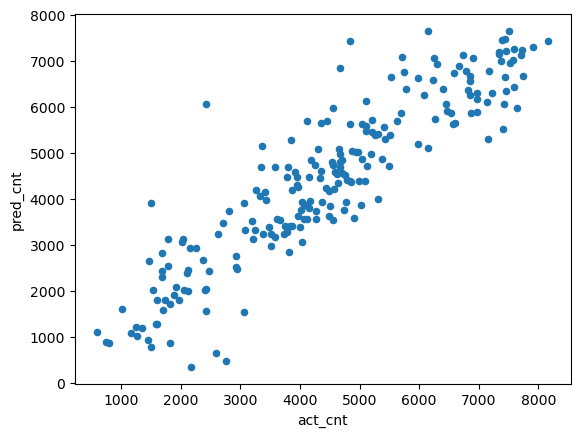

In [24]:
result_df[['act_cnt','pred_cnt']].plot(x = 'act_cnt', y = 'pred_cnt', kind = 'scatter')

In [25]:
mean_squared_error(result_df.act_cnt, result_df.pred_cnt)

652118.8675799087

In [26]:
r2_score(result_df.act_cnt, result_df.pred_cnt)

0.8115724950408901

## First Basic model results -
1. Trained first base model including all features with sklearn
2. Giving R2 score of 0.81


## checking with stats model

In [27]:
import statsmodels.api as sm

In [28]:
remove_cols = ['dteday']

In [29]:
df1 = df.loc[:,[col for col in df.columns if col not in remove_cols] ]

In [30]:
X_train_sm = X_train.copy()

X_train_sm[['yr','holiday','workingday']] = X_train_sm[['yr','holiday','workingday']].astype(int)
X_train_sm = sm.add_constant(X_train_sm)

In [31]:
# Fit the model
model = sm.OLS(y_reg_train_scaled, X_train_sm).fit()

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     107.1
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          8.74e-185
Time:                        00:28:57   Log-Likelihood:                -228.30
No. Observations:                 511   AIC:                             512.6
Df Residuals:                     483   BIC:                             631.2
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.084e+12   1.43e+12     -0.757      0.449    -3.9e+12    1.73e+12
yr               1.0861      0.036     30.391      0.000       1.016       1.156
holiday       3.014e+12   3.98e+12      0.757      0.449   -4.81e+12    1.08e+13
workingday    3.014e+12   3.98e+12      0.757      0.449   -4.81e+12    1.08e+13
season_1      5.229e+11   6.91e+11      0.757      0.449   -8.34e+11    1.88e+12
season_2      5.229e+11   6.91e+11      0.757      0.449   -8.34e+11    1.88e+12
season_3      5.229e+11   6.91e+11      0.757      0.449   -8.34e+11    1.88e+12
season_4      5.229e+11   6.91e+11      0.757      0.449   -8.34e+11    1.88e+12
mnth_1       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_10      -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_11      -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_12      -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_2       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_3       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_4       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_5       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_6       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_7       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_8       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
mnth_9       -2.947e+11   3.89e+11     -0.757      0.449   -1.06e+12     4.7e+11
weekday_0     1.807e+12   2.39e+12      0.757      0.449   -2.88e+12     6.5e+12
weekday_1    -1.207e+12   1.59e+12     -0.757      0.449   -4.34e+12    1.93e+12
weekday_2    -1.207e+12   1.59e+12     -0.757      0.449   -4.34e+12    1.93e+12
weekday_3    -1.207e+12   1.59e+12     -0.757      0.449   -4.34e+12    1.93e+12
weekday_4    -1.207e+12   1.59e+12     -0.757      0.449   -4.34e+12    1.93e+12
weekday_5    -1.207e+12   1.59e+12     -0.757      0.449   -4.34e+12    1.93e+12
weekday_6     1.807e+12   2.39e+12      0.757      0.449   -2.88e+12     6.5e+12
weathersit_1 -9.509e+11   1.26e+12     -0.757      0.449   -3.42e+12    1.52e+12
weathersit_2 -9.509e+11   1.26e+12     -0.757      0.449   -3.42e+12    1.52e+12
weathersit_3 -9.509e+11   1.26e+12     -0.757      0.449   -3.42e+12    1.52e+12
atemp            0.3291      0.044      7.464      0.000       0.242       0.416
hum             -0.1061      0.025     -4.227      0.000      -0.155      -0.057
windspeed       -0.0886      0.019     -4.550      0.000      -0.127      -0.050
==============================================================================
Omnibus:                      161.575   Durbin-Watson:                   2.013
Prob(Omni

In [33]:
model_casual = sm.OLS(y_casual_train_scaled, X_train_sm).fit()

In [34]:
model_casual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     53.84
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          3.18e-127
Time:                        00:28:57   Log-Likelihood:                -370.27
No. Observations:                 511   AIC:                             796.5
Df Residuals:                     483   BIC:                             915.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4.405e+12   1.89e+12     -2.330      0.020   -8.12e+12    -6.9e+11
yr               0.4404      0.047      9.333      0.000       0.348       0.533
holiday       1.225e+13   5.26e+12      2.330      0.020    1.92e+12    2.26e+13
workingday    1.225e+13   5.26e+12      2.330      0.020    1.92e+12    2.26e+13
season_1      2.124e+12   9.12e+11      2.330      0.020    3.33e+11    3.92e+12
season_2      2.124e+12   9.12e+11      2.330      0.020    3.33e+11    3.92e+12
season_3      2.124e+12   9.12e+11      2.330      0.020    3.33e+11    3.92e+12
season_4      2.124e+12   9.12e+11      2.330      0.020    3.33e+11    3.92e+12
mnth_1       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_10      -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_11      -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_12      -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_2       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_3       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_4       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_5       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_6       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_7       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_8       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
mnth_9       -1.197e+12   5.14e+11     -2.330      0.020   -2.21e+12   -1.88e+11
weekday_0     7.341e+12   3.15e+12      2.330      0.020    1.15e+12    1.35e+13
weekday_1    -4.905e+12   2.11e+12     -2.330      0.020   -9.04e+12   -7.68e+11
weekday_2    -4.905e+12   2.11e+12     -2.330      0.020   -9.04e+12   -7.68e+11
weekday_3    -4.905e+12   2.11e+12     -2.330      0.020   -9.04e+12   -7.68e+11
weekday_4    -4.905e+12   2.11e+12     -2.330      0.020   -9.04e+12   -7.68e+11
weekday_5    -4.905e+12   2.11e+12     -2.330      0.020   -9.04e+12   -7.68e+11
weekday_6     7.341e+12   3.15e+12      2.330      0.020    1.15e+12    1.35e+13
weathersit_1 -3.863e+12   1.66e+12     -2.330      0.020   -7.12e+12   -6.05e+11
weathersit_2 -3.863e+12   1.66e+12     -2.330      0.020   -7.12e+12   -6.05e+11
weathersit_3 -3.863e+12   1.66e+12     -2.330      0.020   -7.12e+12   -6.05e+11
atemp            0.4361      0.058      7.492      0.000       0.322       0.550
hum             -0.1008      0.033     -3.040      0.002      -0.166      -0.036
windspeed       -0.0987      0.026     -3.840      0.000      -0.149      -0.048
==============================================================================
Omnibus:                       45.790   Durbin-Watson:                   1.945
Prob(Omni

In [35]:
pd.DataFrame(model.params, columns = ['coeff']).round(4)

,coeff
const,-1.084161e+12
yr,1.086100e+00
holiday,3.014218e+12
workingday,3.014218e+12
season_1,5.228628e+11
season_2,5.228628e+11
season_3,5.228628e+11
season_4,5.228628e+11
mnth_1,-2.946583e+11
mnth_10,-2.946583e+11


## Takeaways -
1. Training model on all features gave too high/low cofficient for - holiday/workingday/season/mnth/weekday/weather
2. Given feature coefficients, this is not a useable model
3. Have to reduce features and try ahain

## removing weekday related features, got it by experimentation that this is adding noise in the weights

In [53]:
X_train_sm = X_train.copy()

X_train_sm[['yr','holiday','workingday']] = X_train_sm[['yr','holiday','workingday']].astype(int)
X_train_sm = sm.add_constant(X_train_sm)
X_train_sm = X_train_sm.loc[:,~X_train_sm.columns.str.contains('weekday_')]

weekday - 0 and 6 are saturday/sunday - combining these 2 together and rest all

In [54]:
# X_train_sm['weekday_weekend'] = X_train_sm[['weekday_0', 'weekday_6']].sum(axis=1)
# X_train_sm['weekday_weekday'] = X_train_sm[['weekday_1', 'weekday_2','weekday_3', 'weekday_4','weekday_5']].sum(axis=1)

# X_train_sm.drop(['weekday_0','weekday_1', 'weekday_2','weekday_3', 'weekday_4','weekday_5','weekday_6'], axis=1, inplace = True)

In [55]:
# Fit the model
model = sm.OLS(y_reg_train_scaled, X_train_sm).fit()

In [56]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     124.5
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          3.20e-184
Time:                        00:31:08   Log-Likelihood:                -242.38
No. Observations:                 511   AIC:                             530.8
Df Residuals:                     488   BIC:                             628.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7809      0.034    -23.269      0.000      -0.847      -0.715
yr               1.0861      0.036     29.829      0.000       1.015       1.158
holiday         -0.0136      0.101     -0.135      0.893      -0.211       0.184
workingday       0.5863      0.039     14.924      0.000       0.509       0.663
season_1        -0.6841      0.073     -9.332      0.000      -0.828      -0.540
season_2        -0.1638      0.073     -2.237      0.026      -0.308      -0.020
season_3        -0.1852      0.075     -2.464      0.014      -0.333      -0.038
season_4         0.2522      0.077      3.295      0.001       0.102       0.403
mnth_1          -0.1594      0.109     -1.459      0.145      -0.374       0.055
mnth_10         -0.0432      0.093     -0.463      0.644      -0.227       0.140
mnth_11         -0.2817      0.103     -2.745      0.006      -0.483      -0.080
mnth_12         -0.2050      0.090     -2.282      0.023      -0.381      -0.029
mnth_2          -0.0356      0.106     -0.337      0.737      -0.243       0.172
mnth_3           0.0381      0.079      0.484      0.629      -0.117       0.193
mnth_4          -0.1170      0.097     -1.210      0.227      -0.307       0.073
mnth_5          -0.0087      0.100     -0.087      0.930      -0.205       0.188
mnth_6          -0.0043      0.091     -0.048      0.962      -0.183       0.174
mnth_7          -0.2111      0.111     -1.895      0.059      -0.430       0.008
mnth_8          -0.0050      0.103     -0.049      0.961      -0.207       0.197
mnth_9           0.2520      0.083      3.039      0.002       0.089       0.415
weathersit_1     0.1867      0.043      4.351      0.000       0.102       0.271
weathersit_2    -0.0166      0.040     -0.419      0.676      -0.094       0.061
weathersit_3    -0.9510      0.090    -10.577      0.000      -1.128      -0.774
atemp            0.3393      0.045      7.546      0.000       0.251       0.428
hum             -0.1167      0.025     -4.598      0.000      -0.167      -0.067
windspeed       -0.0894      0.020     -4.549      0.000      -0.128      -0.051
==============================================================================
Omnibus:                      158.927   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              601.648
Skew:                          -1.382   Prob(JB):                    2.26e-131
Kurtosis:                       7.540   Cond. No.                     5.10e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.19e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [57]:
model_casual = sm.OLS(y_casual_train_scaled, X_train_sm).fit()

In [58]:
model_casual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     64.51
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          4.86e-129
Time:                        00:31:08   Log-Likelihood:                -376.80
No. Observations:                 511   AIC:                             799.6
Df Residuals:                     488   BIC:                             897.0
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2807      0.044      6.429      0.000       0.195       0.366
yr               0.4271      0.047      9.017      0.000       0.334       0.520
holiday         -0.4288      0.131     -3.279      0.001      -0.686      -0.172
workingday      -1.2007      0.051    -23.494      0.000      -1.301      -1.100
season_1        -0.0309      0.095     -0.325      0.746      -0.218       0.156
season_2         0.3567      0.095      3.745      0.000       0.170       0.544
season_3         0.0535      0.098      0.548      0.584      -0.139       0.246
season_4        -0.0987      0.100     -0.991      0.322      -0.294       0.097
mnth_1          -0.2341      0.142     -1.646      0.100      -0.514       0.045
mnth_10          0.4169      0.121      3.434      0.001       0.178       0.655
mnth_11          0.1393      0.134      1.043      0.297      -0.123       0.402
mnth_12         -0.1173      0.117     -1.004      0.316      -0.347       0.112
mnth_2          -0.2995      0.137     -2.179      0.030      -0.570      -0.029
mnth_3           0.1996      0.102      1.948      0.052      -0.002       0.401
mnth_4          -0.0641      0.126     -0.509      0.611      -0.311       0.183
mnth_5           0.1399      0.130      1.076      0.282      -0.116       0.395
mnth_6          -0.1382      0.118     -1.169      0.243      -0.370       0.094
mnth_7          -0.0236      0.145     -0.163      0.871      -0.308       0.261
mnth_8          -0.0005      0.133     -0.004      0.997      -0.263       0.262
mnth_9           0.2623      0.108      2.432      0.015       0.050       0.474
weathersit_1     0.2721      0.056      4.875      0.000       0.162       0.382
weathersit_2     0.1538      0.051      2.991      0.003       0.053       0.255
weathersit_3    -0.1452      0.117     -1.241      0.215      -0.375       0.085
atemp            0.4324      0.059      7.391      0.000       0.317       0.547
hum             -0.1191      0.033     -3.607      0.000      -0.184      -0.054
windspeed       -0.1069      0.026     -4.183      0.000      -0.157      -0.057
==============================================================================
Omnibus:                       57.008   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.252
Skew:                           0.650   Prob(JB):                     2.56e-25
Kurtosis:                       4.904   Cond. No.                     5.10e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.19e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [61]:
X_test_sm = X_test.copy()

X_test_sm[['yr','holiday','workingday']] = X_test_sm[['yr','holiday','workingday']].astype(int)
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm = X_test_sm.loc[:,~X_test_sm.columns.str.contains('weekday_')]

In [62]:
result_df1 = pd.concat([pd.DataFrame(y_reg_scaler.inverse_transform(model.predict(X_test_sm).values.reshape(-1,1)), index = test_df.index, columns = ['reg_pred']).round(),
           pd.DataFrame(y_casual_scaler.inverse_transform(model_casual.predict(X_test_sm).values.reshape(-1,1)), index = test_df.index, columns = ['casual_pred']).round(),
           pd.DataFrame(y_reg_scaler.inverse_transform(y_reg_test_scaled), columns = ['act_registered'], index = test_df.index ),
           pd.DataFrame(y_casual_scaler.inverse_transform(y_casual_test_scaled), columns = ['act_casual'], index = test_df.index )], axis=1)

In [63]:
result_df1['act_cnt'] = result_df1[['act_registered','act_casual']].sum(axis=1)
result_df1['pred_cnt'] = result_df1[['reg_pred','casual_pred']].sum(axis=1)

In [64]:
r2_score(result_df1.act_cnt, result_df1.pred_cnt)

0.823436956220844

In [65]:
pd.set_option('display.float_format', '{:.4f}'.format)

In [69]:
pd.DataFrame(model.params, columns = ['coeff']).round(4).sort_values(by = 'coeff')

,coeff
weathersit_3,-0.9510
const,-0.7809
season_1,-0.6841
mnth_11,-0.2817
mnth_7,-0.2111
mnth_12,-0.2050
season_3,-0.1852
season_2,-0.1638
mnth_1,-0.1594
mnth_4,-0.1170


## Actionables/Outcomes from the model

1. In bad weather, bookings drop significantly, there is nothing we can do about it but plan accordingly
2. Spring season negatively impact the booking, can plan for alternate routes/localities which are uneffected in the spring season
3. There are certain months November, December and July (probably by weather) when bookings are low
4. Humidity and windspeed negatively impacts the booking
5. On other side, higher temperature promotes bookings
6. And bookings are high on working day and year-on-year growth on top of it

# final R2 of the used model -

In [70]:
r2_score(result_df1.act_cnt, result_df1.pred_cnt)

0.823436956220844